# Preprocessing & visualization 

## Introduction

This chapter will guide you through the steps of data preprocessing and visualization. A mentioned earlier, the set of tools for the analysis of single-cell RNA-sequencing data is evolving fast due to new sequencing technologies and a growing number of captured cells, measured genes and identified cell populations. (CITE 1000 Tools Zappia) Many of these tools are dedicated to preprocessing which aims to address the following analysis steps: doublet detection, quality control, normalization, feature selection, and dimensionality reduction. Preprocessing is a crucial step in scRNA-seq data analyis. The tools selected throughout this chapter can heavily affect downstream analysis and interpretation of the data. For example, if you filter out too many cells during quality control, you might loose rare cell subpopulations and miss insight into interesting cell biology. Whereas if you are too permissive, you might have a hard time annotating your cells if you did not exclude poor quality cells in your preprocessing pipeline. Therefore, it is important to select tools that provide a best practice and that proved to outperform other with respect to downstream tasks. In many cases, you will still have to re-assess your preprocessing analyis and change, for example, your filtering strategy. This is natural and the daily stuggle and challenge of every computational biologist. 

To help analyists with their choice of different preprocessing tools, {cite}`germain_pipecomp_2020` provided a pipeline comparison *PipeComp* to benchmark different preprocessing steps and their effect on downstream analysis steps. In the following, we refer to the tools recommended in this independent benchmark and complement is with python based tools that are frequently used by the scRNA-seq community. This chapter will additionally introduce the advanced topics of ambient RNA, single nuclei and interactive visualization. 

The starting point of this notebook are raw sequencing data generated by sequencing machines. The data was processed and aligned to obtain matrices of molecular counts, so called count matrices, or read counts (read matrices). The difference between count and read matrices depends on whether unique molecular identifiers (UMIs) were included in the single-cell library construction protocol. Read and count matrices have the dimension number of barcodes x number of transcripts. It is important to note that the term "barcode" is used here instead of "cell" as a barcode might wrongly have tagged multiple cells (doublet) or might have not tagged any cell (empty droplet/well). We will elaborate more on this in the next section "Doublet detection". 

### Dataset
We first load the dataset with scanpy which can be downloaded from figshare (ADD LINK). We use a human bone marrow dataset from .... CITE. 

In [2]:
import scanpy as sc
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
adata = sc.read('cellranger_neurips21_bmmc.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


After reading the data, scanpy displays a warining that not all variable names are unique. We execute the proposed function and hav a look into out AnnData object. 

In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 131515 × 36601
    obs: 'site', 'donor'
    var: 'gene_ids', 'feature_types', 'genome'

The dataset has the shape `n_obs` 131,515 x `n_vars` 36,601. This translates into barcodes x number of transcripts. We additionally inspect further information in `.obs` such as site and donor providing us some more information on the origin of each barcode and in `.var` additionally gene_ids (Ensembl Id), feature_types and genome. As the dataset contains data from several sites and donors, we inspect those further by ccounting their values. 

In [5]:
adata.obs.value_counts(['site', 'donor'], sort=False)

site   donor  
site1  donor1      8442
       donor2      8341
       donor3      5626
site2  donor1      6319
       donor4     10062
       donor5      8246
site3  donor1      1649
       donor3     18732
       donor6      2355
       donor7      2734
       donor10    17521
site4  donor1     16337
       donor8     16934
       donor09     8217
dtype: int64

We can inspect that *donor1* is annotated across all sites, so we create a new column in obs specifying sample, i.e. the combination of site and donor to get an unique identifier for each sample. 

In [6]:
adata.obs['sample'] = [f"{adata.obs['site'][i]}-{adata.obs['donor'][i]}" for i in range(adata.shape[0])]

Having now the data at hand, we will now start with the actual preprocessing. 

## Doublet Detection

Doublets are defined as two cells that are sequenced under the same cellular barcode, so for example if they were captured in the same droplet. We therefore used so far the term "barcode" instead if "cell". A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise. Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs. Hence, their identification is not the main goal of the doublet detection methods. 

Doublets formed from different cell types or states are called heterotypic. Their identification is crucial as they are most likedly misclassified and can lead to distorted downstream analysis steps. Hence, doublet detection and removal is typically an initial preprocessing step. Doublets can be either identified through their high number of reads and detected features, or with methods that create atrifical doublets and comparing these with each cell. Doublet detection methods are computationally efficient and the exist several software packages for this tasks, to mention a few: *scDblFinder*,  *scds*, *DoubletFinder* or *scran’s doubletCells*. {cite}`germain_pipecomp_2020` showed that distribution-based cell filtering fails to capture doublets and computation tools should be preferred for detection of doublets and they proposed to use scDblFinder as it enhanced downstream clustering results. 

The scDblFinder R package collects several methods for the detection of doublets in scRNA-seq data and identifies heterotypic doublets which are in many cases also the most critical ones as stated above. scDblFinder works on raw count matrices and can be used for datasets with multiple samples. It will use this information to generate artificial doublets and the nearest neighbors are identifies for each sample separatly. The overall scoring is then performed globally and sample-specific doublet rates will be considered for the threshold. scDblFinde expects an `SingleCellExperiment` object of shape number of transcripts x barcodes which does not contain empty drops, but other than that has not been filtered before. We will now apply the method to the transposed raw count matrix `.X`. To use scDblFinder on multiple samples we additionally provide a vector of the sample ids and allow multithreading using the BPPARAM parameter. Both parameters can be ignored if your dataset only consists of one sample.

scDblFinder can be used by loading the followingen python and R packages. 

In [7]:
import pandas as pd
import numpy as np

import anndata2ri
import logging
import warnings
warnings.filterwarnings('ignore')

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [8]:
%%R
library(Seurat)
library(scDblFinder)
library(scater)
library(BiocParallel)

In [9]:
data_mat = adata.X.T
sample_ids = pd.factorize(adata.obs['sample'])[0]

We can now launch the doublet detection by using `data_mat` (and `sample_ids`) as input to scDblFinder within a SingleCellExperiment. scBblFinder adds several columns to the colData of sce, three of them might be interesting for the analyist:

* `sce$scDblFinder.score` : the final doublet score (the higher the more likely that the cell is a doublet)

* `sce$scDblFinder.ratio` : the ratio of artificial doublets in the cell's neighborhood

* `sce$scDblFinder.class` : the classification (doublet or singlet)

We will only output the `class` argument and store it in the anndata object in `.obs`
. The other arguments can be added to the anndata object in a similar way. 

In [10]:
%%R -i data_mat -i sample_ids -o droplet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ), 
    samples=sample_ids, 
    BPPARAM=MulticoreParam(3), 
    verbose=TRUE
)
droplet_class = sce$scDblFinder.class

In [11]:
adata.obs['scDblFinder_class'] = droplet_class
adata.obs.scDblFinder_class.value_counts()

singlet    110153
doublet     21362
Name: scDblFinder_class, dtype: int64

All cells classified as doublet are now removed from the dataset. 

In [12]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[adata.obs.scDblFinder_class=='singlet'].copy()

print(f"Number of cells after filtering of doublets: {adata.n_obs}")

Total number of cells: 131515
Number of cells after filtering of doublets: 110153



<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-away</b></p>
<p style='margin-left:1em;'>
Doublet can be efficiently detected with tools like scDblFinder and outperform distribution-based filtering techniques. 

</p>
</span>
</div>

## Quality Control

Apart from doublets, the dataset might contain low-quality cells which are filtered by cell quality control (QC). Cell QC is typically performed on the following three QC covariates: the number of counts per barcode (count depth), number of genes per barcode, and fraction of counts from mitochondrial genes per barcode. In cell QC these covariates are filtered via thresholding as they might correspond to dying cells. They might reflect cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. These cells might then show a low count depth, few detected genes and a high fraction of mitochondrial reads. It is, however, crucial to consider the three QC covariates jointly as otherwise it might lead to misinterpretation of cellular signal. Cells with a relativly high fraction of mitochondrial counts might for example be involved in respiratory processes and should not be filtered out. Whereas, cells with low or high counts might correspond to quiescent cell populations or cells larger in size. It is therefore prefered to consider multiple covariates when thesholding decisions on single covariates are made. In general, it is advised to exclude fewer cells and be as permissive as possible to avoid filtering out viable cell populations or small sub-populations. 

QC on datasets is often performed in a manual fashion by looking at the distribution of different QC covariates. However, as datasets grow in size it might be worth to consider automatic thresholding via MAD (median absolute deviations). {cite}`germain_pipecomp_2020` proposed in their study to mark cells as outliers if they differ by 5 MADs. {cite}`germain_pipecomp_2020` useing the `isOutlier` function from *scatter* for efficient MAD-filtering. This notebook uses an equivalent python function to apply the same filtering strategy. 

In QC, the first step is to calculate the QC covariates or metric. We compute these using the scanpy function `sc.pp.calculate_qc_metrics`, which can also calculate the proportions of counts for specific gene populations. We therefore define mitochondrial, ribosomal and hemoglogin genes. It is important to note that mitochondrial counts are annotated either with the prefix "mt-" or "MT-" depending on the species considered in the dataset. As mentioned, the dataset used in this notebook is human bone narrow, so mitochondrial counts are annotated with the prefix "MT-". For mouse datasets, the prefix is usually lower case, so "mt-".


In [13]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

We can now calculate the respective QC metrics with scanpy. This will add several new columns to `.var` and `.obs` as seen below. 

In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 110153 × 36601
    obs: 'site', 'donor', 'sample', 'scDblFinder_class', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

We now plot the three QC covariates `n_genes_by_counts`, `total_counts` and `ct_counts_Mt` per sample to assess how well the respective cells were captured. 

... storing 'sample' as categorical


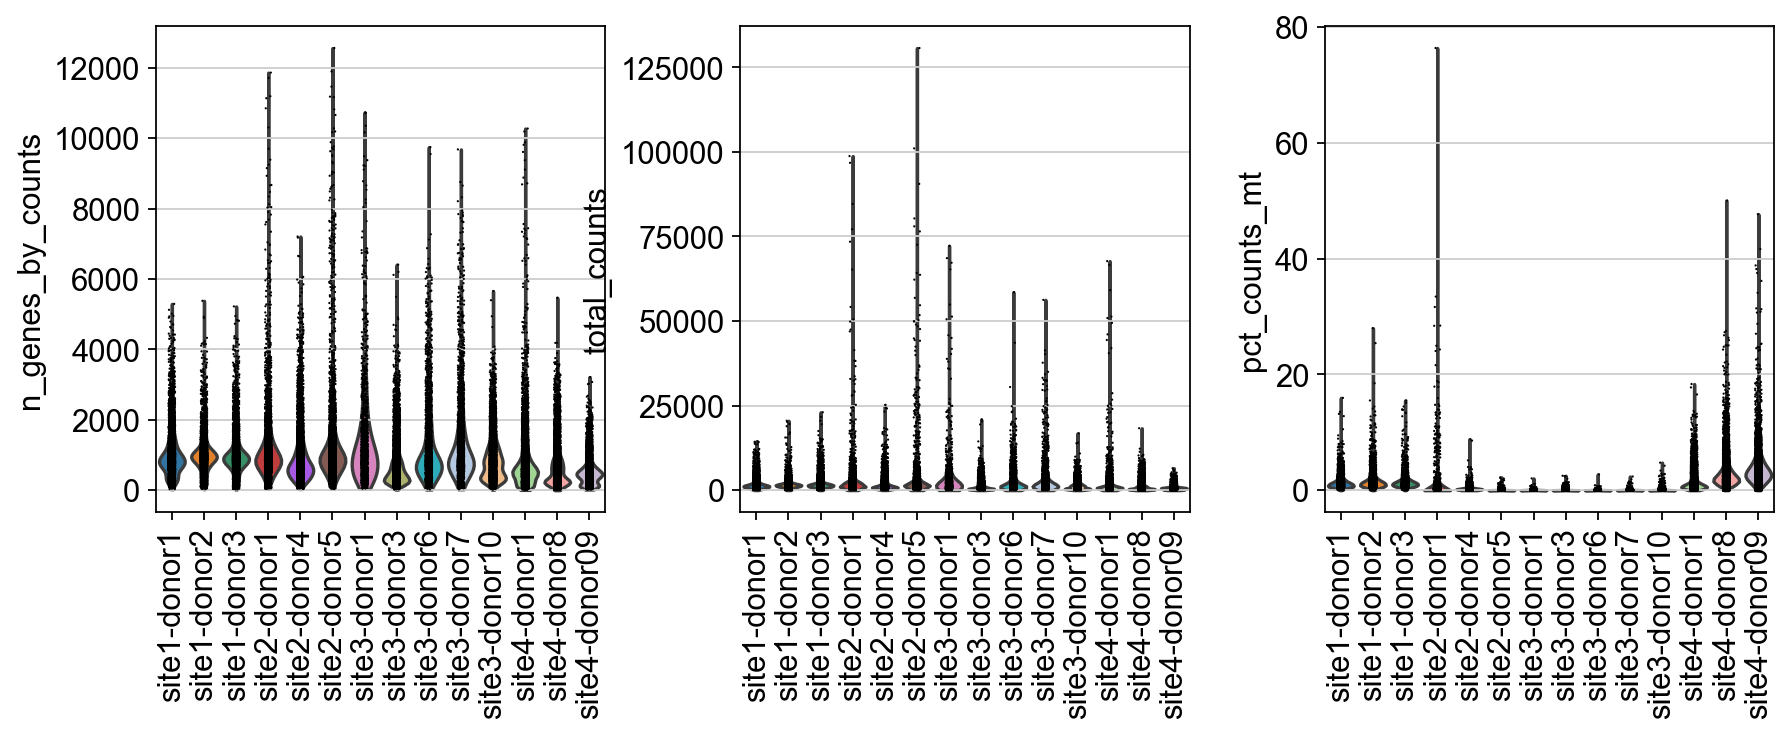

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby = 'sample', rotation= 90)

The plots show that site2-donor1, site4-donor8 and site4-donor09 have the poorest quality in comparison as they show a relatively high percentage of mitochondrial counts which are often associated with cell degradation. But since number of counts per cell is  sufficiently high and precentage of mitochondrial reads is for most cells below 20 % we can still process these samples. Based on these plots, one could now also define manual thresholds for filtering cells. Instead we will show sample-wise QC with automatic thresholding and filtering based on MAD. For this purpose, we define a function that takes a `metric`, i.e. a column in `.obs` and the number of MADs (nmad) that is still permissive within the filtering strategy. 

In [16]:
def isOutlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (np.median(M) + nmads * M.mad() < M)
    return outlier

We now apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs.

In [17]:
outliers = []
for sample in np.unique(adata.obs['sample']):
    adata_temp = adata[adata.obs['sample'] == sample].copy()
    adata_temp.obs['outlier'] = isOutlier(adata_temp, 'log1p_total_counts', 5) | isOutlier(adata_temp, 'log1p_n_genes_by_counts', 5) | isOutlier(adata_temp, 'pct_counts_in_top_20_genes', 5) 
    outliers.append(adata_temp.obs['outlier'])
    print(
        f"{sample}: outliers {adata_temp.obs.outlier.value_counts()[True]}"
    )

site1-donor1: outliers 154
site1-donor2: outliers 331
site1-donor3: outliers 301
site2-donor1: outliers 251
site2-donor4: outliers 143
site2-donor5: outliers 240
site3-donor1: outliers 38
site3-donor10: outliers 362
site3-donor3: outliers 204
site3-donor6: outliers 27
site3-donor7: outliers 48
site4-donor09: outliers 142
site4-donor1: outliers 224
site4-donor8: outliers 343


In [18]:
adata.obs = adata.obs.join(pd.concat(outliers))
adata.obs.outlier.value_counts()

False    107345
True       2808
Name: outlier, dtype: int64

`pct_counts_Mt` is filtered with 3 MADs accorind to the recommendation by {cite}`germain_pipecomp_2020`. Additionally, cells with a percentage of mitochondrial counts exceding 8 % are filtered out.

In [19]:
mt_outliers = []
for sample in np.unique(adata.obs['sample']):
    adata_temp = adata[adata.obs['sample'] == sample].copy()
    adata_temp.obs['mt_outlier'] = isOutlier(adata_temp, 'pct_counts_mt', 3) | (adata_temp.obs['pct_counts_mt'] > 8)
    mt_outliers.append(adata_temp.obs['mt_outlier'])
    print(
        f"{sample}: mt outliers {adata_temp.obs.mt_outlier.value_counts()[True]}"
    )

site1-donor1: mt outliers 372
site1-donor2: mt outliers 330
site1-donor3: mt outliers 232
site2-donor1: mt outliers 167
site2-donor4: mt outliers 381
site2-donor5: mt outliers 423
site3-donor1: mt outliers 105
site3-donor10: mt outliers 799
site3-donor3: mt outliers 1077
site3-donor6: mt outliers 149
site3-donor7: mt outliers 118
site4-donor09: mt outliers 444
site4-donor1: mt outliers 972
site4-donor8: mt outliers 646


In [20]:
adata.obs = adata.obs.join(pd.concat(mt_outliers))
adata.obs.mt_outlier.value_counts()

False    103938
True       6215
Name: mt_outlier, dtype: int64

We now filter our anndata object based on these two additional columns. 

In [21]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 110153
Number of cells after filtering of low quality cells: 101721


To reduce th runtime for the next chapters, we are subsampling the dataset with scanpy. 

In [22]:
sc.pp.subsample(adata, fraction=0.1)

{cite}`germain_pipecomp_2020` does not recommend to filter cells based on feature type. However, *sctransform* normalization will filter out genes that are not detected in at least 5 cells, so we will apply the same filtering strategy already here.

In [23]:
print(f"Total number of genes: {adata.n_vars}")

# Min 5 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 21722



<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-aways</b></p>
<p style='margin-left:1em;'>
    
- Filtering of poor-quality cells should be based on median absolute deviations with lenient cutoffs to avoid bias against smaller subpopulations.
    
- Feature-based filtering does not show benefits for downstream tasks. 

</p>
</span>
</div>

## Normalization

Up to this point, we removed doublets and low quality cells from the dataset and the data is available as a count matrix. These counts represent the capture, reverse transcription and sequencing of a molecule in the scRNA-seq experiment. Each of these steps adds a degreee of variability to the measured count depth for identical cells, so the difference in gene expression between cells in the count data might simply be due to sampling effects. The preprocessing step of "Normlaization" addresses these problems. Several normalization techniques are used in practice. One common approach is count depth scaling, i.e. counts per million (CPM) normalization. CPM normalization assumes that initally all cells in the dataset contained an equal number of molecules ad that the difference in count depth is only due to sampling. However, as datasets usually consist of heterogeneous cell populations which different cell sizes and molecule counts, more complex normalization methods are needed. 

We now introduce the reader to the normalization with *sctransform*. Sctransform was motivated by the observation that cell-to-cell variation in scRNA-seq data might be counfounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from 'regularized negative binomial regression' to calculate a model of technical noise in the data. Sctransform adds the count depth as a covariate in a generalied linear model. {cite}`germain_pipecomp_2020` showed in an independent comparision of different normalization techniques that this method removed the impact of sampling effects while preserving cell heteogeneity in the dataset. Sctransform does not require downsteam heuristic steps like pseudocount addition or log-transformation.

The output of sctransform are normalized values that can be positive or negative. Negative residuals for a cell and gene indicate that less counts are observed than expected compared to the gene's average expression and cellular sequencing depth. Positive residuals indicate the more counts respectively.  

We first load the additionally required python and R packages.


In [24]:
from scipy.sparse import issparse

In [25]:
%%R
library(sctransform)

The dataset used in this chapter has a sparse representation of the count matrix, so we sort the indices and add the AnnData object to the R environment.

In [26]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()
ro.globalenv['adata'] = adata

The object is now transformed into a Seurat object with original expression annotated as "RNA" and we can call sctransform with the "glmGamPoi" method. Sctranform allows the user to only keep variable genes, we set this option to False as we are only interested in the normalization of the data. We additionally set the number of subsampling cells `ncells` to 3000 to reduce the runtime of sctransform. This number is used to build the NB regression and the default is 5000. You can adjust this number based on the compute power you have at hand.

In [27]:
%%R
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")
res <- SCTransform(object=seurat_obj, method = "glmGamPoi", return.only.var.genes = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Sctransform stores the result in the "SCT" assay in the Seurat object. The "SCT" assay contains the following matrices:

* `res[["SCT"]]@scale.data` stores the normalized values, the residuals, which can be used as input to PCA. This matrix is non-sparse so it is rather memory-costly for all genes. By setting the argument `return.only.var.genes` to `TURE` we can save memory and sctransform will only store variable genes. However, in this case the sctransform feature selection method is used and {cite}`germain_pipecomp_2020` recommend to use deviance as stated in the following chapter.

* sctransform additionally stored the 'corrected' UMI counts which can be interpreted as the number of counts one would observe if all cells were sequenced to the same depth. They are stored in `res[["SCT"]]@counts`.

* `res[["SCT"]]@data` contains a log-normalized version of the corrected counts. They may be helpful for visualization, differential expression analysis and integration. Generally, sctransform recommends to use the residuals directly for downstream tasks.

We now extract the residuals and save it to the AnnData object. As `sctransform` returns a gene by cell matrix, we transpose it and save it as a new layer. The residuals can then be used for further downstream analysis steps. 

In [28]:
norm_x = ro.r('res@assays$SCT@scale.data').T
adata.layers['SCT_normalized_residuals'] = norm_x

## Feature Selection

We now have a normalized data representation that still preserves biological heterogenity but with reduced technical sampling effects in gene expression. So far we only removed genes that are not detected in at least 5 cells. However, in almost all cases we want to further reduce the dimensionality of the dataset and only include the most informative genes. Therefore, a standard preprocessing pipeline involves the step of feature selection which aims to exlude uninformative genes which might not represent meaningful biological variation across samples. Usually, the scRNA-seq experiment and resulting dataset focuses on one specific tissue and hence, only a small fraction of genes are informative and biologically variable. Traditional approaches and piplines either compute the coefficient of variation (highly variable genes) or the average expression level (highly expressed genes) of 500-2000 selected genes and use these features for their downstream analysis steps. However, these methods are highly sensitive to the normalization technique used before. As mentioned earlier, a former preprocessing workflow included normalization with CPM and subsequent log transformation. But as log-transformation is not possible for exact zeros, analysts often add a small *pseudocount*, e.g. 1 (log1p), to all normalized counts before log transforming the data. Choosing the pseudocount, however, is arbitrary and can introduce biases to the transformed data. This arbitrariness has then also an effect on the feature selection as the observed variability depends on the chosen pseudocount. A small pseudocount value close to zero is increasing the variance of genes with zero counts. (CITE https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6). 

{cite}`germain_pipecomp_2020` instead proposes to use *deviance* for feature selection which works on raw counts. Deviance can be computed in closed form and quantifies whether genes show a constant expression profile acrosss cells as these are not informative. Genes with constant expression are described by a multinomial null model, they are approximated by the bionmial deviance. Highly informative genes across cells will have a high deviance value which indicates a poor fit by the null model (i.e. they don't show constant expression across cells). Accorrding to the deviance values, the method then ranks all genes and obtains only highly deviant genes. 

As mentioned before, deviance can be computed in closed form and is provided within the R package scry.


In [29]:
%%R
library(scry)

Similar to before, we save the AnnData object in our R environment. 

In [30]:
ro.globalenv['adata'] = adata

We can now directly call feature selection with deviance on the non-normalized counts matrix and export the bionomial deviance values as a vector. 

In [31]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [32]:
binomial_deviance = ro.r('rowData(sce)$binomial_deviance').T

As a next step, we now sort the vector an select the top 4,000 highly deviant genes and save them as an additional column in `.var` as 'highly_deviant'. 

In [33]:
idx = binomial_deviance.argsort()[-4000:]
msk = np.zeros(adata.var_names.shape, dtype=bool)
msk[idx] = True

adata.var['highly_deviant'] = msk

We additionally store the highly deviant genes under the keyword 'highly_variable' in `.var` to use these genes downstream in dimensionality reduction.

In [34]:
adata.var['highly_variable'] = msk

## Dimensionality Reduction

As already mentioned, scRNA-seq is a high-throughput sequencing technology that produces datasets with high dimensions in the number of cells and genes. This immediatly points to the fact that scRNA-seq data suffers from the 'curse of dimensionality'. Not all genes are informative and are important for the task of cell type clustering based on their expression profiles. Therefore, an important step during preprocessing is dimensionaliy reduction which is used to reduce the data complexity and for visualization. Several dimensionality reduction techniques have been developed.

{cite}`10.3389/fgene.2021.646936` compared in an independent comparison the stability, accuracy and computing cost of 10 different dimensionality reduction methods. They propose to use t-distributed stochastic neighbor embedding (t-SNE) as it yielded the best overall performance. Uniform manifold approximation and projection (UMAP) showed the highest stability and separates best the original cell populations. An additional dimensionality reduction worth to mention in this context is principal component analysis (PCA) which is still widely used. 

All aforementioned methods are implemented in scanpy. We start with:

### PCA

In out dataset each cell is a vector of a `n_var`-dimensional vector space spanned by some orthonormal basis. As scRNA-seq suffers from the 'curse of dimensionality', we know that not all features are important to understand the underlying dynamics of the dataset and that there is an inherent redundancy. PCA creates a new set of uncorrelated variable, so called principle components (PCs), via an orthoginal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC component amounts to the largest possible variance. PCs with the lowest variance are discarded to effictively reduce the dimensionality of the data without loosing information.

PCA offers the advantage that it his highly interpretable and computationally efficient. However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate. PCA is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.


### t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points. Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.


### UMAP

UMAP is a graph based, non-linear dimensionality technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph.


We first calculate PCA and subsequently a neighborhood graph on our data.

In [35]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(adata)

In [36]:
sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)

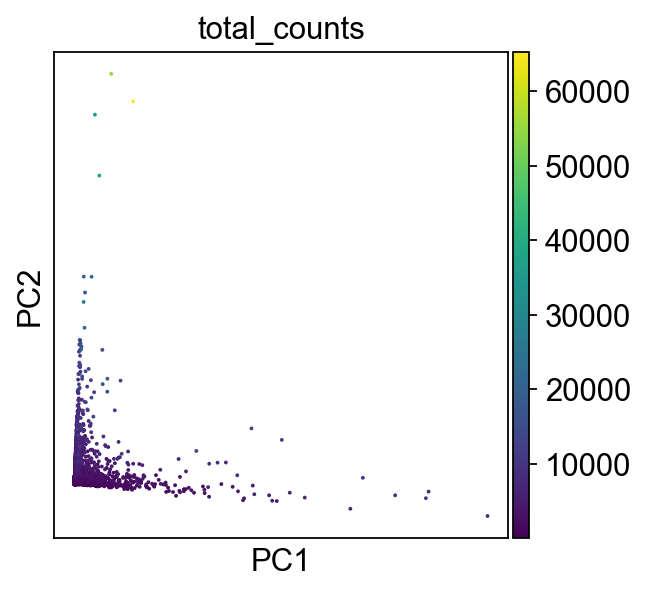

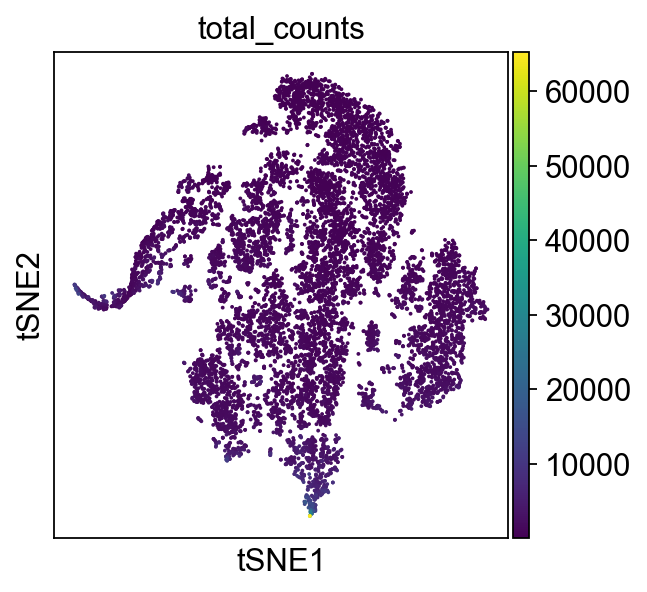

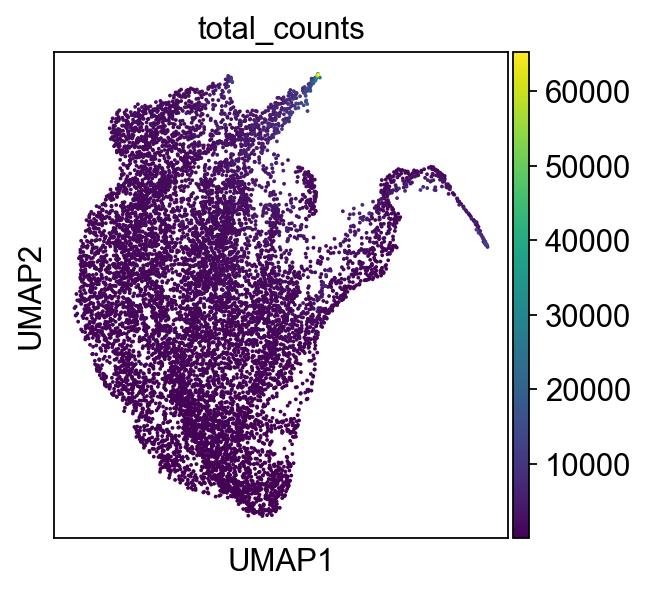

In [39]:
sc.pl.pca_scatter(adata, color='total_counts')
sc.pl.tsne(adata, color='total_counts')
sc.pl.umap(adata, color='total_counts')

## References

```{bibliography}
:filter: docname in docnames
```

In [30]:
import session_info
session_info.show()